# Project Final Code

Title: AIRBNB Price Prediction-Austin Metro. Area  
Student Id: ubm700  
Course:CS6463  
Index:  
1. [Obtaining the Data](#Obtaining-the-Data)
    - [AIRBNB Dataset](#AIRBNB-DATASET)
    - [Austin Crime Map](#Austin-Crime-Map)
    - [Google Drive Link](#Google-Drive-Download)

2. [Setup](#Setup)
 

3. [Data Preparation](#Data-Preparation)
    - [Dataset Description Dictionaries](#Dataset-Description-Dictionaries)
    - [Utility Functions](#Utility-Functions)
    - [Data Reading Functions](#Data-Reading-Functions)
    - [Preprocessing](#Preprocessing)
        - [Drop Duplicates](#Drop-Duplicates)
        - [Zipcode Intersection](#Zipcode-Intersection)
    - [Feature Engineering](#Feature-Engineering)
        - [Create Regions](#Create-Regions)
        - [Derive Crime Rate](#Derive-Crime-Rate)

4. [Data Exploration](#Data-Exploration)
    - [Price (Target) Analysis](#Price-(Target)-Analysis)
        - [Boxpot](#Price-Boxplot)
        - [Quantiles](#Price-Quantiles)
        - [Distribution](#Price-Distribution)
        - [Handle Outliers](#Handle-Price-Outliers)
    - [Feature Analysis](#Feature-Analysis)
        - [Handle Missing Values](#Handle-Missing-Feature-Values)
	- [Correlation Matrix](#Correlation-Matrix)
	- [Location Analysis](#Location-Analysis)
		- [Region Crime Analysis](#Crimes-and-Listings-by-Region)
		- [Region Map](#Region-Map)
	- [Listing Anaysis](#Listing-Analysis)
		- [Price Map](#Price-Map)
		- [Listing by Region](#Listings-Analysis)
		- [Price by Region](#Price-by_Region)
		- [Accomodates Analysis](#Accomodates-Analysis)
		- [Property Analysis](#Property-Analysis)
		- [Room Type Analysis](#Room-Type-Analysis)
		- [Bedroom Analysis](#Bedroom-Analysis)
		- [Bathroom Analysis](#Bathroom-Analysis)
    - [Reviews Analysis](#Reviews-Analysis)
        - [Overall Rating](#Overall-Rating)
        - [Accuracy Rating](#Accuracy-Rating)
        - [Cleanliness Rating](#Cleanliness-Rating)
        - [Check-In Rating](#Check-In-Rating)
        - [Communication Rating](#Communication-Rating)
        - [Location Rating](#Location-Rating)
        - [Value Rating](#Value-Rating)
    - [Amenities Analysis](#Amenities-Analysis)
        - [Expand Amenities](#Expand-Amenities)
        - [Top 15 Amenities](#Top-15-Amenities)
        
5. [Modeling](#Modeling)
    - [Data Overview](#Data-Overview)
    - [One Hot Encode Categorical Features](#One-Hot-Encode-Categorical-Features)
    - [Test-Train Split Data](#Test-Train-Split)
    - [Scaling/Standardizing Data](#Scaling/Standardizing-Data)
    - [Sci-kit Learn Pipeline](#Sci-kit-Learn-Pipeline)
    - [Sci-kit Learn Results](#Sci-kit-Learn-Results)
    - [XG-Boost Gridsearch](#XG-Boost-Grid-Search)
    - [XG-Boost Results](#XG-Boost-Results)
    - [Cross Validation](#Cross-Validation)

6. [Presentation Graphics](#Presentation-Graphic(s))



## Obtaining the Data
The data required for this project may be obtained as follows.

### AIRBNB DATASET
The airbnb dataset is divided into three subsets `listings`, `calendar`, and `reviews` for each geographic area they support.  Each subset is available in a monthly timeframe from the AIRBNB website. I downloaded a year's worth of data and extracted, renamed, and reorganized the csv file into manageable directories.  

After performing this operations I uploaded the dataset to google to allow for easy access for the instructor. 
[Google Drive Download Link](https://drive.google.com/file/d/18cvdgvF9S9emxnNzl8XmUU0QmnDVdfX-/view?usp=sharing)

- Source: AIRBNB
- Source URL: http://insideairbnb.com/get-the-data.html
- City: Austin, Tx
- Data Range: August 2018 - July 2019
- License: Creative Commons CC0 1.0
- Subsets used `listings`	


```bash
#!/usr/bin/env bash

#extract csv from GZ archives
gunzip -d *

#create folders to seperate out data
mkdir listings
mkdir reviews
mkdir calendars

#move CSVs into folders using REGEX/WILDCARDS
mv ~/AIRBNB/*"listings.csv" ~/AIRBNB/listings
mv ~/AIRBNB/*"reviews.csv" ~/AIRBNB/reviews
mv ~/AIRBNB/*"calendar.csv" ~/AIRBNB/calendars
```

### Austin Crime Map

- Source: Austin City Government Open Data Portal
- Source URL: https://data.austintexas.gov/Public-Safety/Crime-Reports-2018-Map/fc3e-daxz
- City: Austin, Tx
- Data Range: 01/01/2018 and 12/31/2018
- License: Public Domain

### Google Drive Download

An organized directory zip is available at
[Google Drive Download Link](https://drive.google.com/file/d/18cvdgvF9S9emxnNzl8XmUU0QmnDVdfX-/view?usp=sharing)

## Setup

In [1]:
"""
README - All execution code has been put into functions labeled by the major block they are in.
At the end of each section an execution code block runs all the code blocks for that section. 


The import statments below need to be removed from docstrings

"""

"""

# OS Tools
import os

# Utilities
import tabulate
from collections import Counter

# Data Science Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score


#Set Base Directory (THIS POINTS TO THE DATA FOLDERS)
base_path = './../'

# Fig array
save_figs = True

# Matplotlib configurations
SMALL_SIZE = 12
JUST_RIGHT_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)            # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=JUST_RIGHT_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)      # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)      # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)      # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)    # fontsize of the figure title


"""

## Data Preparation

### Dataset Description Dictionaries

These general mappings aid in filtering, selecting, and cleaning off features.  
I created these myself by opening the datasets in excel to identify the data type
for each feature.

In [2]:
# Global Utility Dictionaries and References
def global_dictionaries():
    
    global month_lookup
    global listings_columns
    global calendar_columns
    
    # string month to number map
    month_lookup = {
        "january": 1,
        "february":2,
        "march":3,
        "april":4,
        "may":5,
        "june":6,
        "july":7,
        "august":8,
        "september":9,
        "october":10,
        "november":11,
        "december":12}


    #listings dataset attribute tags
    listings_columns = {
        'id': 'nominal int',
        'listing_url': 'nominal str',
        'scrape_id': 'nominal extraneous str',
        'last_scraped': 'ordinal extraneous datetime',
        'name': 'plaintext str',
        'summary': 'plaintext str',
        'space': 'plaintext str',
        'description': 'plaintext str',
        'experiences_offered': 'plaintext extraneous str',
        'neighborhood_overview': 'plaintext str',
        'notes': 'plaintext str',
        'transit': 'plaintext str',
        'access': 'plaintext str',
        'interaction': 'plaintext str',
        'house_rules': 'plaintext str',
        'thumbnail_url': 'nominal extraneous str',
        'medium_url': 'nominal extraneous str',
        'picture_url': 'nominal extraneous str',
        'xl_picture_url': 'nominal extraneous str',
        'host_id': 'nominal numerical int',
        'host_url': 'nominal extraneous str',
        'host_name': 'nominal str',
        'host_since': 'ordinal datetime',
        'host_location': 'nominal str',
        'host_about': 'plaintext str',
        'host_response_time': 'ordinal str',
        'host_response_rate': 'percentage str convert',
        'host_acceptance_rate': 'percentage str convert',
        'host_is_superhost': 'boolean',
        'host_thumbnail_url': 'nominal extraneous str',
        'host_picture_url': 'nominal extraneous str',
        'host_neighbourhood': 'nominal str',
        'host_listings_count': 'discrete int',
        'host_total_listings_count': 'discrete int',
        'host_verifications': 'nominal list',
        'host_has_profile_pic': 'boolean',
        'host_identity_verified': 'boolean',
        'street': 'nominal str',
        'neighbourhood': 'nominal str',
        'neighbourhood_cleansed': 'nominal str',
        'neighbourhood_group_cleansed': 'nominal str',
        'city': 'nominal str',
        'state': 'nominal str extraneous',
        'zipcode': 'nominal int convert zipcode feature',
        'market': 'nominal str extraneous',
        'smart_location': 'nominal str extraneous',
        'country_code': 'nominal str extraneous',
        'country': 'nominal str extraneous',
        'latitude': 'continous float',
        'longitude': 'continous float',
        'is_location_exact': 'boolean',
        'property_type': 'nominal str feature',
        'room_type': 'nominal str feature',
        'accommodates': 'discrete int feature',
        'bathrooms': 'discrete int feature',
        'bedrooms': 'discrete int feature',
        'beds': 'discrete int feature',
        'bed_type': 'nominal str feature',
        'amenities': 'nominal list feature',
        'square_feet': 'discrete int feature',
        'price': 'continous monetary str convert',
        'weekly_price': 'continous monetary str convert',
        'monthly_price': 'continous monetary str convert',
        'security_deposit': 'continous monetary str convert feature',
        'cleaning_fee': 'continous monetary str convert feature',
        'guests_included': 'discrete int feature',
        'extra_people': 'continous monetary str convert feature',
        'minimum_nights': 'discrete int feature',
        'maximum_nights': 'discrete int feature',
        'minimum_minimum_nights': 'discrete extraneous int',
        'maximum_minimum_nights': 'discrete extraneous int',
        'minimum_maximum_nights': 'discrete extraneous int',
        'maximum_maximum_nights': 'discrete extraneous int',
        'minimum_nights_avg_ntm': 'discrete extraneous int',
        'maximum_nights_avg_ntm': 'discrete extraneous int',
        'calendar_updated': 'nominal extraneous str',
        'has_availability': 'boolean',
        'availability_30': 'discrete extraneous int',
        'availability_60': 'discrete extraneous int',
        'availability_90': 'discrete extraneous int',
        'availability_365': 'discrete extraneous int',
        'calendar_last_scraped': 'nominal extraneous datetime',
        'number_of_reviews': 'discrete int feature',
        'number_of_reviews_ltm': 'discrete extraneous int',
        'first_review': 'ordinal extraneous datetime',
        'last_review': 'ordinal extraneous datetime',
        'review_scores_rating': 'discrete int feature',
        'review_scores_accuracy': 'ordinal int feature',
        'review_scores_cleanliness': 'ordinal int feature' ,
        'review_scores_checkin': 'ordinal int feature',
        'review_scores_communication': 'ordinal int feature',
        'review_scores_location': 'ordinal int feature',
        'review_scores_value': 'ordinal int feature',
        'requires_license': 'boolean',
        'license': 'nominal extraneous int',
        'jurisdiction_names': 'nominal extraneous str',
        'instant_bookable': 'boolean',
        'is_business_travel_ready': 'boolean',
        'cancellation_policy': 'nominal str',
        'require_guest_profile_picture': 'boolean',
        'require_guest_phone_verification': 'boolean',
        'calculated_host_listings_count': 'discrete int',
        'calculated_host_listings_count_entire_homes': 'discrete extraneous int',
        'calculated_host_listings_count_private_rooms': 'discrete extraneous int',
        'calculated_host_listings_count_shared_rooms': 'discrete extraneous int',
        'reviews_per_month': 'discrete extraneous float'}

    #calendar dataset attribute tags
    calendar_columns = {
        'listing_id': 'nominal int',
        'date': 'ordinal datetime',
        'available': 'boolean',
        'price': 'continous monetary str convert',
        'adjusted_price': 'continous monetary str convert',
        'minimum_nights': 'discrete int',
        'maximum_nights': 'discrete int'}
    
    
#global_dictionaries()


### Utility Functions

These functions provide general purpose utilities

In [3]:
# Utility Functions

# create markdown for reports
def to_markdown(df):
    with open('./table.txt', 'w') as f:
        mdn = tabulate.tabulate(df.round(2), tablefmt="pipe", headers = "keys")
        f.write(mdn)
        
    return mdn


def info_to_markdown():
    with open('./raw.txt','r') as f:
        y = [['idx', 'Columns', 'Count', 'Null', 'Dtype']]
        i = 0
        for line in f:
            x = [el for el in line.strip().split(' ') if el is not ""]
            x.insert(0, i)
            i = i + 1
            y.append(x)    
    with open('./table.txt', 'w') as f:
        mdn = tabulate.tabulate(y, tablefmt="pipe", headers="firstrow" )
        f.write(mdn)

        
        
def describe_to_markdown():
    with open('./raw.txt','r') as f:
        y = [['Statistic', 'Value']]
        for line in f:
            x = [el for el in line.strip().split(' ') if el is not ""]
            y.append(x)    
    with open('./table.txt', 'w') as f:
        mdn = tabulate.tabulate(y, tablefmt="pipe", headers="firstrow" )
        f.write(mdn)


### Data Reading Functions

These are the primary functions to load in the datasets. 
They perform the majority of the cleaning and type conversions. 
To do this they rely on the predefined dictionaries in [DataSet Descriptions](#Dataset-Description-Dictionaries)

In [4]:
#Read functions for our datasets

#combining all monthly data into yearly dataframes
def load_listing(sCSVPATH):
    """
    function to load listings csv
    irrelevant columns excluded, photo urls, etc..
    low_memory flag set in exploratory phase
    """
    #filter columns to drop with 'extraneous tag'
    drop_cols = [col for col in listings_columns if 'extraneous' in listings_columns[col]]
    
    #read df
    df = pd.read_csv(os.path.join(base_path, "listings", sCSVPATH), na_values = ['N/A', 'none'], low_memory=False)
    
    #drop columns if they exist
    for col in drop_cols:
        if col in df.columns:
            df.drop(col, axis = 1, inplace = True)
            
    #perform data conversions
    converts = [col for col in listings_columns if 'convert' in listings_columns[col]]
    percentage = [col for col in converts if 'percentage' in listings_columns[col]]
    monetary = [col for col in converts if 'monetary' in listings_columns[col]]
    
    for col in percentage:
        df[col] = df[col].replace('[^.0-9]', '', regex = True).astype(float)
    
    for col in monetary:
        df[col] = df[col].replace('[^.0-9]', '', regex = True).astype(float)
    
    
    # drop NA zipcodes
    df.dropna(subset = ['zipcode'], inplace = True)
    
    # Clean up zipcodes
    df['zipcode'] = df['zipcode'].replace(r'.*(\d{5}).*', r'\1', regex = True).astype(int)
    
    # store month as column for later indexing
    df['month'] = month_lookup[sCSVPATH.split('_')[0]]
    
    
    # drop columns that are all  NA
    
    df.dropna(axis = 1, how = "all", inplace = True)
    return df



def load_calendar(sCSVPATH):
    """
    function to load calendar csv
    low_memory flag set in exploratory phase
    """
   
    #read df
    df = pd.read_csv(os.path.join(base_path, "calendars", sCSVPATH), na_values = ['N/A', 'none'], parse_dates = ['date'], low_memory=False) 
    
    #perform data conversions
    converts = [col for col in calendar_columns if 'convert' in calendar_columns[col]]
    monetary = [col for col in converts if 'monetary' in calendar_columns[col]]
    
    for col in monetary:
        if col in df.columns:
            df[col] = df[col].replace('[^.0-9]', '', regex = True).astype(float)
    
    #drop NAN price
    df.dropna(subset=['price'], inplace = True)
    return df


def load_crimes(sCSVPATH):
    #read df
    df = pd.read_csv(os.path.join(base_path, "crime", sCSVPATH), low_memory = False)
    
    #drop NA zipcodes
    df.dropna(subset = ['Zip Code'], inplace = True)
    
    #Clean up zipcodes
    df['zipcode'] = df['Zip Code'].replace(r'.*(\d{5}).*', r'\1', regex = True).astype(int)
    return df

In [5]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Preparation_0():
    
    # Declare dfs as global to escape scope
    global df_listings
    global df_calendars
    global df_crimes
    global feature_lst
    
    
    # Load CSV Data into DataFrames
    listings_by_months = [ load_listing(file) for file in os.listdir(os.path.join(base_path, "listings")) if file.endswith(".csv")]

    #combine into singular df for whole year
    df_listings = pd.concat(listings_by_months, sort = False)

    #load all monthly listings into list
    calendars_by_months = [ load_calendar(file) for file in os.listdir(os.path.join(base_path, "calendars")) if file.endswith(".csv")]

    #combine into singular df for whole year
    df_calendars = pd.concat(calendars_by_months, sort = False)

    # load crimes dataset
    df_crimes = load_crimes('Crime_Reports_2018_Map.csv')

    # Create empty list of features we would like to track
    feature_lst = list()



# Data_Preparation_0()


### Preprocessing

Here we remove duplicate listings based on `drop_mode` either `soft` or `hard`.
Furthermore since both the listings dataset and the crimes dataset share `zipcode`
as a feature we must align and trim the datasets to the intersection of each respective
`zipcode` column

#### Drop Duplicates

In [6]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Preparation_1():
    
    # Declare dfs as global to escape scope
    global df_listings
    global df_calendars
    global df_crimes
    global feature_lst
    
    # Remove Duplicates since multi month listing concatenation

    # in soft mode two listings of the same id and price but of different months
    # are considered non duplicates

    # in all other modes any listings with the same id and price are considered 
    # duplicates

    soft_drop = False

    if soft_drop:
        df_listings.drop_duplicates(keep="first", inplace=True)

    else:
        df_listings.drop_duplicates(subset = ["id", "price"], keep="first", inplace=True)
    print(df_listings.shape)
    
    
    
# Data_Preparation_1()


#### Zipcode Intersection

In [7]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Preparation_2():
    
    # Declare dfs as global to escape scope
    global df_listings
    global df_calendars
    global df_crimes
    global feature_lst
    global zipcodes

    # Extract sets of zipcodes
    listings_zipcodes = set(df_listings['zipcode'].values)
    crimes_zipcodes = set(df_crimes['zipcode'].values)

    # perform intersection
    zipcodes = listings_zipcodes.intersection(crimes_zipcodes)

    # trim each df based on membership in zipcodes

    df_listings = df_listings[df_listings['zipcode'].isin(zipcodes)]
    df_crimes = df_crimes[df_crimes['zipcode'].isin(zipcodes)]


# Data_Preparation_2()

### Feature Engineering

In [8]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""


def Data_Preparation_3():
    
    # Declare dfs as global to escape scope
    global df_listings
    global df_calendars
    global df_crimes
    global feature_lst
    global zipcodes
    global region_map

    # Divide zipcodes into regions

    #Source https://www.realtyaustin.com/zip-codes.php
    #modifed and extended from https://medium.com/@daniel.j.cummings/exploring-and-predicting-airbnb-rental-prices-in-austin-texas-88cfa10258fd
    
    zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
    zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751, 78756, 78758, 78759, 78757, 78641, 78681]
    zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
    zip_south = [78737, 78739, 78745, 78749, 78748, 78742, 78617, 78652]
    zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 78744, 78747, 78752, 78753, 78754, 78613,78653,78660]


    # create dictionary map zipcode -> region
    region_map = dict()

    for code in zipcodes:
        if code in zip_central:
            region_map[code] = "central"
        elif code in zip_north:
            region_map[code] = "north"
        elif code in zip_west:
            region_map[code] = "west"
        elif code in zip_south:
            region_map[code] = "south"
        elif code in zip_east:
            region_map[code] = "east"
        else:
            raise Exception("Code not found")

    # Create crime rate column form dictionary
    df_listings['region'] = df_listings['zipcode'].map(region_map)

    
# Data_Preparation_3()

#### Derive Crime Rate


In [9]:

"""
EXECUTION CODE UNCOMMENT TO RUN
"""


def Data_Preparation_4():
    
    # Declare dfs as global to escape scope
    global df_listings
    global df_calendars
    global df_crimes
    global df_crime_rate
    global feature_lst
    global zipcodes

    # Generate crime ratio between number of crimes and zipcode and region


    #Extract zipcode counts from each DataSet
    listings = df_listings['zipcode'].value_counts()
    listings.rename('listings', inplace = True)

    crimes = df_crimes['zipcode'].value_counts()
    crimes.rename('crimes', inplace = True)

    # Combine into one DataFrame
    df = pd.concat([listings, crimes], axis = 1)


    # Add region
    df['region'] = df.index.map(region_map)

    feature_lst.append('region')

    # Divide to get ratio
    df['crime_rate'] = df['crimes'] / df['listings']

    # Convert to dictionary map 
    crime_map = dict(df['crime_rate'])

    # Create crime rate column form dictionary
    df_listings['crime_rate_zipcode'] = df_listings['zipcode'].map(crime_map)

    # Add crime rate to features list
    feature_lst.append('crime_rate_zipcode')

    # repeat operations for region

    df = df.groupby(by = 'region').sum()

    # Divide to get ratio
    df['crime_rate'] = df['crimes'] / df['listings']

    # Convert to dictionary map 
    crime_map = dict(df['crime_rate'])

    # Create crime rate column form dictionary
    df_listings['crime_rate_region'] = df_listings['region'].map(crime_map)

    # Add crime rate to features list
    feature_lst.append('crime_rate_region')
    
 
    df_crime_rate = df.copy()


# df_crime_rate = Data_Preparation_4()



In [10]:
"""
EXECUTION CODE UNCOMMENT/DOCSTRING REMOVE TO RUN
"""

"""
global_dictionaries()
Data_Preparation_0()
Data_Preparation_1()
Data_Preparation_2()
Data_Preparation_3()
Data_Preparation_4()

"""

(24889, 69)


## Data Exploration

### Price (Target) Analysis

In [11]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_0():

    #look at stats
    print(df_listings['price'].describe())
    
    
# Data_Exploration_0()


#### Price Boxplot

In [12]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_1():
    
    # look at boxplot
    props = {"marker" : '.', "markerfacecolor" : 'green', "markeredgecolor":'green'}
    df_listings['price'].plot(kind='box', xlim=(0,2750), vert = False, figsize = (16,2),flierprops = props )
    plt.title("Price Boxplot, limit 2750")


    if save_figs:
        plt.savefig("./plots/price_boxplot_1",  dpi = 300, bbox_inches='tight')
    else:
        plt.show()
        
# Data_Exploration_1()

#### Price Quantiles


In [13]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_2():

    #look at quantiles more closely 
    qrange = np.arange(0, 1, 0.05)
    for q in qrange:
        print('{:.2f}, {:.2f}'.format(q, df_listings['price'].quantile(q)))

# Data_Exploration_2()

#### Price Distribution

In [14]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_3():

    # look at Target Price Distribution

    fig, axes = plt.subplots(1,2, figsize=(21,6))
    sns.distplot(df_listings['price'],kde = True, ax=axes[0])
    sns.distplot(np.log1p(df_listings['price']), ax=axes[1])
    axes[1].set_xlabel('log(1+price)')
    fig.suptitle("Price Distributions", fontsize = 20)

    if save_figs:
        plt.savefig("./plots/price_distribution_1", dpi = 300, bbox_inches='tight')
    else:
        plt.show()
        
        
# Data_Exploration_3()


#### Handle Price Outliers


In [15]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_4():
    
    global df_listings

    # Remove outliers
    cut_upper = (np.log1p(df_listings['price']) > 6.5)
    cut_lower = (np.log1p(df_listings['price']) < 3.5)

    df_listings.drop( df_listings[cut_upper | cut_lower].index, axis = 0, inplace = True)
    
    
# Data_Exploration_4()

In [16]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_5():
    
    fig, axes = plt.subplots(1,2,figsize = (21,6))
    sns.distplot(df_listings['price'], kde = True, ax = axes[0])
    sns.distplot(np.log1p(df_listings['price']), ax=axes[1])
    axes[1].set_xlabel('log(1+price)')
    fig.suptitle("Price Distributions 2", fontsize = 20)

    if save_figs:
        plt.savefig("./plots/price_distribution_2", dpi = 300, bbox_inches='tight')
    else:
        plt.show()

# Data_Exploration_5()

In [17]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_6():

    # look at stats
    print(df_listings['price'].describe())
    

# Data_Exploration_6()


### Feature Analysis

In [18]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""



def Data_Exploration_7():
    
    global feature_lst

    #Now lets look at the distributions of the features

    # create list of features from columns dictionary
    feature_lst.extend([k for k in listings_columns if 'feature' in listings_columns[k]])


    #check for missing values by selecting on features
    print(df_listings[feature_lst].isna().sum())

    
# Data_Exploration_7()

#### Handle Missing Feature Values


In [19]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""


def Data_Exploration_8():
    
    global df_listings
    
    #Deal with missing feature values


    # can't have listings without beds, bathrooms, etc.. that's absurd
    df_listings.dropna(subset = ['bathrooms', 'bedrooms', 'beds'], inplace = True)


    review_cols = ['review_scores_accuracy',
                   'review_scores_checkin',
                   'review_scores_cleanliness',
                   'review_scores_communication',
                   'review_scores_location',
                   'review_scores_rating',
                   'review_scores_value']


    drop_reviews = False

    if drop_reviews:
        # drop listings with 0 reviews
        df_listings.dropna(subset = review_cols, inplace = True)
    else: 
        # fill with average
        for col in review_cols:
            df_listings[col].fillna((int(df_listings[col].mean())), inplace = True)


    # Set cleaning fee to 0 if missing
    df_listings['cleaning_fee'].fillna(0.00, inplace=True)

    # Set security deposit to 0 if missing
    df_listings['security_deposit'].fillna(0.00, inplace=True)
    
    
# Data_Exploration_8()





In [20]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_9():

    #check for missing values by selecting on features
    print(df_listings[feature_lst].isna().sum())

    print(df_listings['price'].describe())

    #See how dropping square_feet nulls affects DataSet
    print(df_listings.dropna(subset = ['square_feet'])['price'].describe())

    # To much data loss by dropped NULL square feet. Remove it from features
    feature_lst.remove('square_feet')

    print(df_listings['price'].describe())

    print(df_listings.shape)
    
# Data_Exploration_9()

#### Correlation Matrix


In [21]:
# correlation plot function
def cor_matrix(df):
    corr = df[df.select_dtypes(include=['float64', 'int64', 'bool']).columns].corr()

    fig1, ax1 = plt.subplots(figsize = (12,9))
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                cmap="YlGnBu")
    
    ax1.set_title("Correlation Matrix")
    return fig1

In [22]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""


def Data_Exploration_10():
    
    # correlation plot
    fig1 = cor_matrix(df_listings)
    if save_figs:
        plt.savefig("./plots/corr_matrix",  dpi = 300, bbox_inches='tight')
    else:
        plt.show()
        
# Data_Exploration_10()

#### Location Analysis

##### Crimes and Listings by Region

In [23]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_11():
    
    # plot
    df_crime_rate[['crimes', 'listings']].plot(kind='barh', figsize = (8,6))

    plt.ylabel('Region')
    plt.title("Crime and Listings by Region (RAW)")

    if save_figs:
        plt.savefig("./plots/crimebyregion", bbox_inches='tight')
    else:
        plt.show()
        
# Data_Exploration_11()

##### Region  Map

In [24]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""


def Data_Exploration_12():
    

    region_markers = {

        'central':'*',
        'north':"2",
        'east':'+',
        'south':',',
        'west':'*'
    }

    plt.figsuze = (16,9)
    for region in region_markers:

        sub = df_listings[df_listings['region'] == region]
        plt.scatter(x=sub["longitude"],
                    y=sub["latitude"],
                    alpha = 0.6,
                    marker = region_markers[region],
                    );
    
    plt.show()
    
# Data_Exploration_12()
    
    
    

#### Listings Analysis

##### Price Map

In [25]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_13():

    df_listings.plot(kind="scatter",
                     x="longitude",
                     y="latitude",
                     alpha=0.4,
                     figsize=(10,7), 
                     c="price",
                     cmap="summer",
                     colorbar=True,
                     sharex=False);

    plt.title(" Price Map")
    if save_figs:
        plt.savefig("./plots/pricemap", bbox_inches='tight')
    else:
        plt.show()
    
# Data_Exploration_13()
    
    

##### Listings by Region

In [26]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_14():
    df_listings['region'].value_counts().sort_values().plot(kind='barh', color='blue')
    plt.title('Number of Accommodations per Region');
    
# Data_Exploration_14()



##### Price by Region

In [27]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_15():
    
    
    opt = dict(markerfacecolor='darkslateblue', markeredgecolor='darkslateblue', marker='.')

    df_listings.boxplot(column = 'price', by = 'region', vert = False, figsize = (8,6), flierprops = opt)

    plt.xlabel('Price')
    plt.ylabel('Region')
    plt.title('Price by Region')
    plt.suptitle("")


    if save_figs:
        plt.savefig("./plots/boxplotpriceregion", bbox_inches='tight')
    else:
        plt.show()

    
# Data_Exploration_15()



##### Accommodates Analysis

In [28]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_16():
    opt = dict(markerfacecolor='indigo', markeredgecolor='indigo', marker='.')

    df_listings.boxplot(column = 'price', by = 'accommodates', vert = False, figsize = (6,6), flierprops = opt)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Accommodates', fontsize=12)
    plt.title('Price by Accommodates', fontsize=14, fontweight='bold')
    plt.suptitle("")
    plt.show()
    
# Data_Exploration_16()



##### Property_Analysis

In [29]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_17():

    plt.figure(figsize=(10,10))
    p = sns.heatmap(df_listings.groupby(['property_type', 'region']).size().unstack(fill_value=0), cmap='Greens', annot=True, cbar_kws ={'label': 'Counts'}, fmt=".0f")
    p.set_title("Property Types by Region")

    plt.xlabel('Region')
    plt.ylabel('Property Type')
    if save_figs:
        plt.savefig("./plots/propertytyperegion", bbox_inches='tight')
    else:
        plt.show()


# Data_Exploration_17()


##### Room Type Analysis

In [30]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_18():
    plt.figure(figsize=(10,10))
    p = sns.heatmap(df_listings.groupby(['accommodates', 'room_type']).price.mean().unstack(), cmap='summer', annot=True, cbar_kws ={'label': 'Mean Price'}, fmt=".0f")

    plt.xlabel('Room Type')
    plt.ylabel('Accommodates')
    plt.title('Room Type, Accommodates, and Price');


    if save_figs:
        plt.savefig("./plots/roomtypeaccommodatesprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_18()





##### Bedroom Analysis

In [31]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_19():
    plt.figure(figsize=(8,6))
    sns.heatmap(df_listings.groupby(['region', 'bedrooms']).price.median().unstack(), 
                cmap='YlOrBr',  cbar_kws ={'label': 'Median Price'},  annot=True, fmt=".0f")

    plt.xlabel('Bedrooms')
    plt.ylabel('Region')
    plt.title('Bedrooms, Regions, and Price');

    if save_figs:
        plt.savefig("./plots/bedroomsregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_19()



In [32]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_20():

    plt.figure(figsize=(10,10))
    x = sns.heatmap(df_listings.groupby(['beds', 'bedrooms']).price.mean().unstack(), annot=True,  cbar_kws ={'label': 'Mean Price'}, fmt=".0f")


    plt.xlabel('Bedrooms')
    plt.ylabel('Beds')
    plt.title('Bedrooms, Beds, and Price');

    if save_figs:
        plt.savefig("./plots/bedroomsbedsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_20()



##### Bathroom Analysis

In [33]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_21():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['bathrooms', 'bedrooms']).price.median().unstack(), 
                cmap='YlOrBr',  cbar_kws ={'label': 'Median Price'},  annot=True, fmt=".0f")

    plt.xlabel('Bedrooms')
    plt.ylabel('Bathrooms')
    plt.title('Bedroom, Bathroom, Mean Price');

    if save_figs:
        plt.savefig("./plots/bedroomsbathroomsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_21()



### Reviews Analysis

#### Overall Rating

In [34]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_22():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_rating', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Rating Score')
    plt.title('Ratings, Region, Price');

    if save_figs:
        plt.savefig("./plots/ratingsregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_22()



#### Accuracy Rating

In [35]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_23():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_accuracy', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy, Region, Price');

    if save_figs:
        plt.savefig("./plots/accuracyregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_23()


#### Cleanliness Rating

In [36]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Data_Exploration_24():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_cleanliness', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Cleanliness Score')
    plt.title('Cleanliness, Region, Price');

    if save_figs:
        plt.savefig("./plots/cleanlinessregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_24()


#### Check-In Rating

In [37]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_25():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_checkin', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Check-In Score')
    plt.title('Check-In, Region, Price');

    if save_figs:
        plt.savefig("./plots/checkinregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_25()



#### Communication Rating

In [38]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_26():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_communication', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Communication Score')
    plt.title('Communication, Region, Price');

    if save_figs:
        plt.savefig("./plots/communicationregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_26()



##### Location Rating

In [39]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_27():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_location', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Location Score')
    plt.title('Location, Region, Price');

    if save_figs:
        plt.savefig("./plots/locationregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_27()



##### Value Rating

In [40]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_28():
    plt.figure(figsize=(8,10))
    sns.heatmap(df_listings.groupby(['review_scores_value', 'region']).price.mean().unstack(), 
                cmap='BuPu',  cbar_kws ={'label': 'Mean Price'},  annot=True, fmt=".0f")

    plt.xlabel('Region')
    plt.ylabel('Value Score')
    plt.title('Value, Region, Price');

    if save_figs:
        plt.savefig("./plots/valueregionsprice", bbox_inches='tight')
    else:
        plt.show()    
    
# Data_Exploration_28()



### Amenities Analysis

#### Expand Amenities

In [41]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

# Expand Amenities column of sets out into columns


#convert set to list
def clean_set(s):
    #Strip and replace out brackets & quotes
    s = s.strip('{}[]')
    s = s.replace("(", '')
    s = s.replace(")", '')
    s = s.replace("'", '')
    s = s.replace('"', '')
    # split on comma to convert to python list
    s = s.split(',')
    # remove AIRBNB transcoding error
    s = [el for el in s if 'translation' not in el]
    return s



def Data_Exploration_29():
    global df_listings
    
    df_listings['amenities_list'] = df_listings['amenities'].apply(clean_set)
    
    
# Data_Exploration_29()







In [42]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_30():
    
    global amenity_count
    
    count = Counter()
    df_listings['amenities_list'].apply(count.update)
    amenity_count = count.most_common()    

    
# amenity_count = Data_Exploration_30()

# Counter to check out amenity popularity



In [43]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_31():
    global feature_lst
    global amenity_lst
    
    # create boolean columns for each amenity per listing
    feature_lst.remove('amenities')

    amenity_lst = list()
    for a in amenity_count:
        if a[0] != "" and a[1] != 0:  

            # add amenity to feature list
            amenity_lst.append(a[0])

            # create the column
            df_listings[a[0]] = df_listings['amenities'].str.contains(a[0])    
    
# Data_Exploration_31()



#### Top 15 Amenities

In [44]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Data_Exploration_32():
    
    global df
    
    df = pd.DataFrame(amenity_count[:15], columns = ['amenity', 'count']).set_index('amenity'). sort_values('count')
    df.plot(kind = 'barh', y = 'count', color = 'lightslategray' )


    plt.xlabel('Count')
    plt.ylabel('Amenity')
    plt.title('Top 15 Amenities')

    if save_figs:
        plt.savefig("./plots/top15amenities", bbox_inches='tight')
    else:
        plt.show()
    
    
# Data_Exploration_32()



count    24859.000000
mean       321.222374
std        816.062107
min          0.000000
25%         80.000000
50%        140.000000
75%        273.000000
max      24999.000000
Name: price, dtype: float64
0.00, 0.00
0.05, 37.00
0.10, 49.00
0.15, 59.00
0.20, 70.00
0.25, 80.00
0.30, 90.00
0.35, 100.00
0.40, 110.00
0.45, 125.00
0.50, 140.00
0.55, 150.00
0.60, 175.00
0.65, 199.00
0.70, 225.00
0.75, 273.00
0.80, 336.40
0.85, 431.00
0.90, 600.00
0.95, 1000.00
count    17577.000000
mean       176.152756
std        134.176954
min         33.000000
25%         80.000000
50%        130.000000
75%        225.000000
max        660.000000
Name: price, dtype: float64
region                             0
crime_rate_zipcode                 0
crime_rate_region                  0
zipcode                            0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         26
bedrooms                           5
beds  

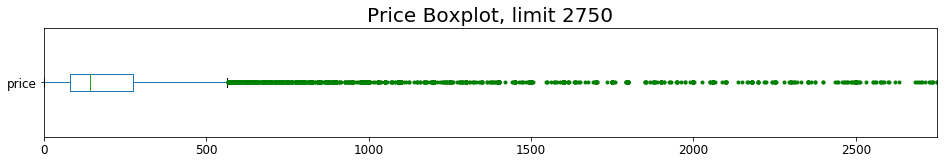

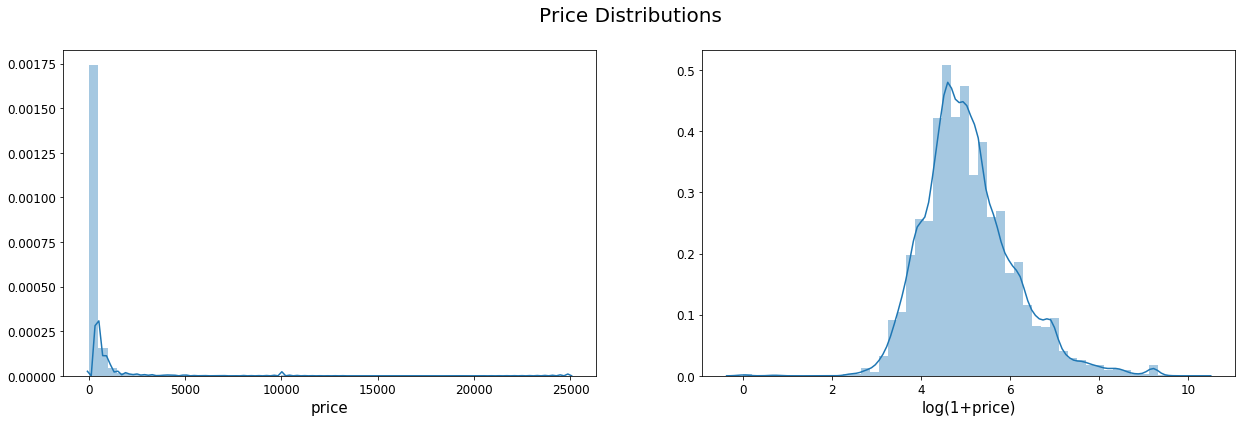

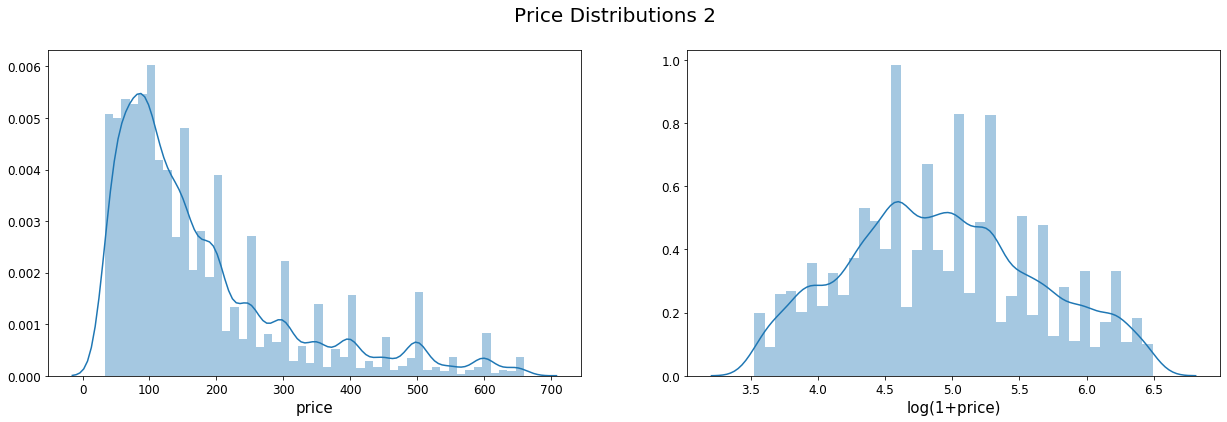

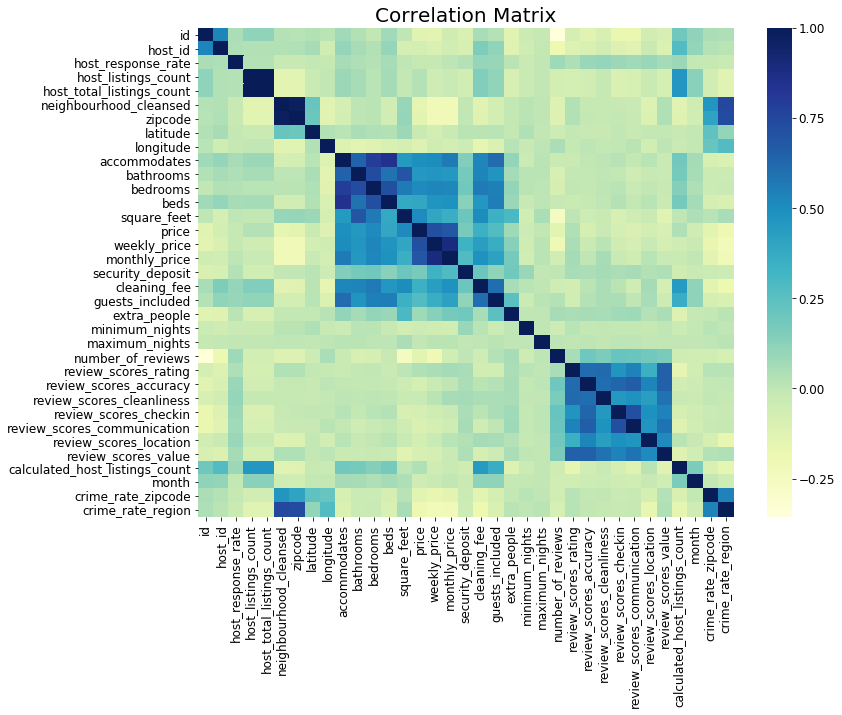

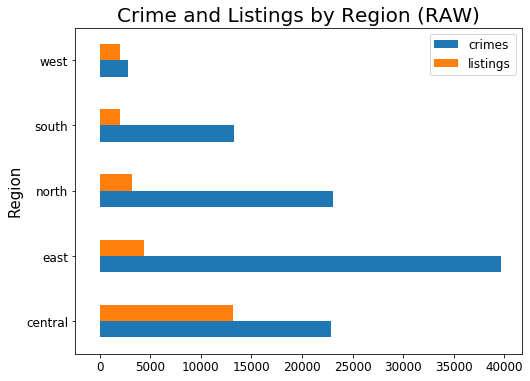

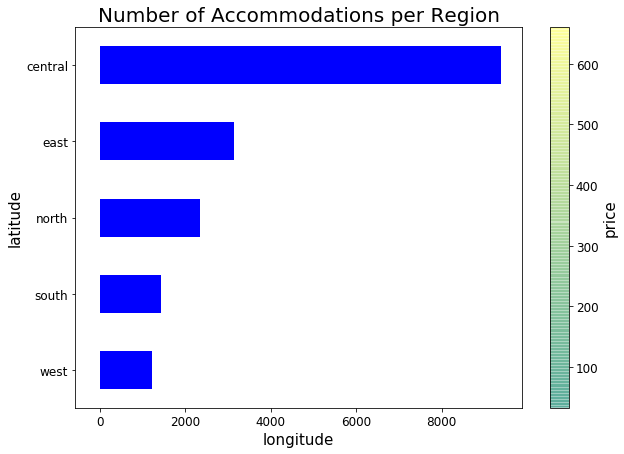

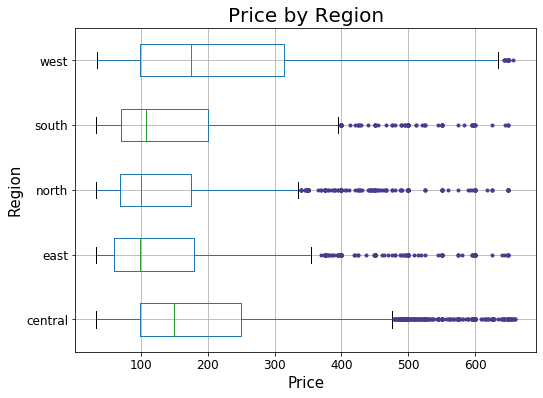

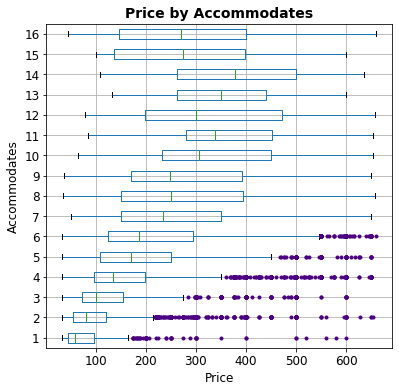

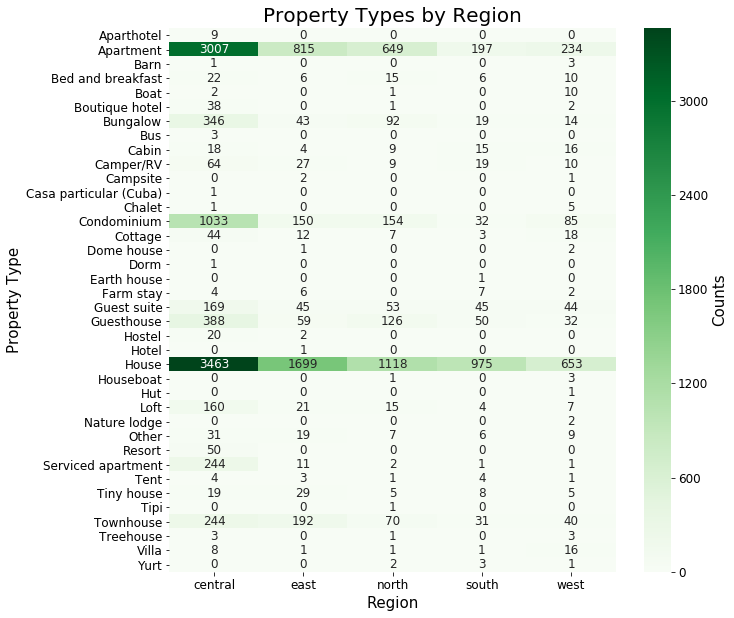

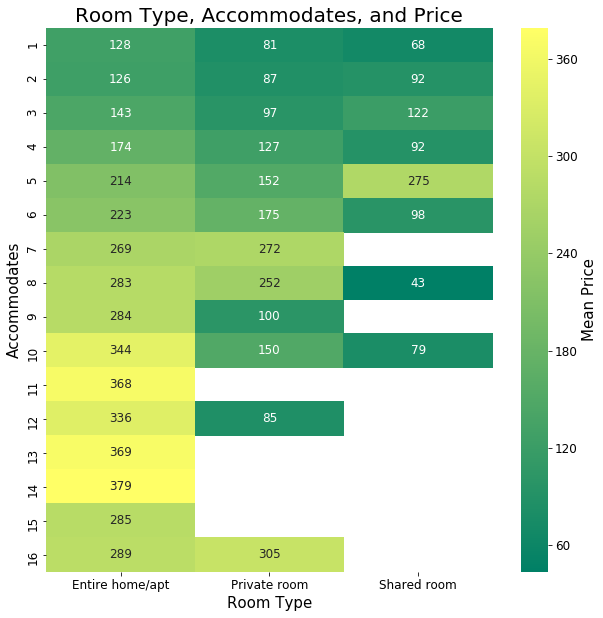

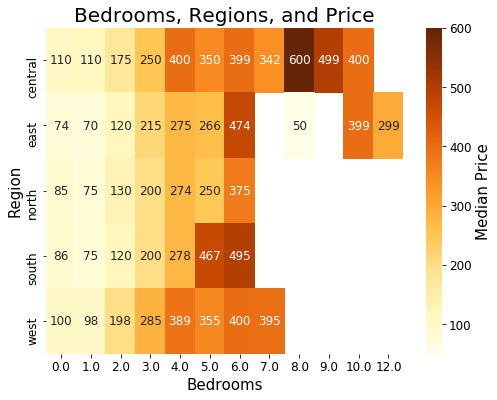

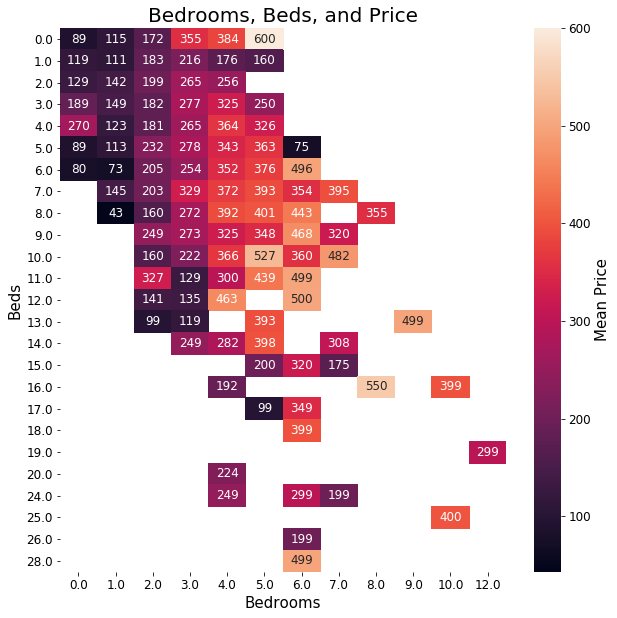

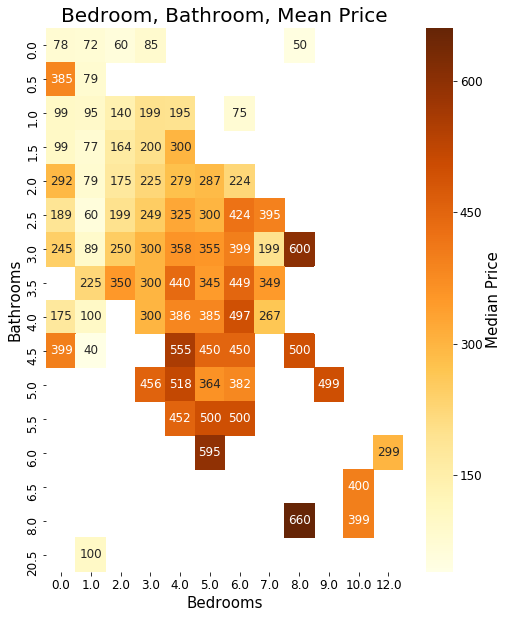

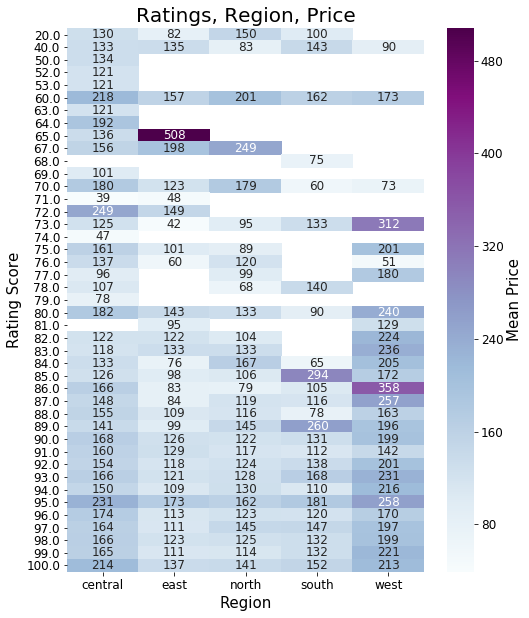

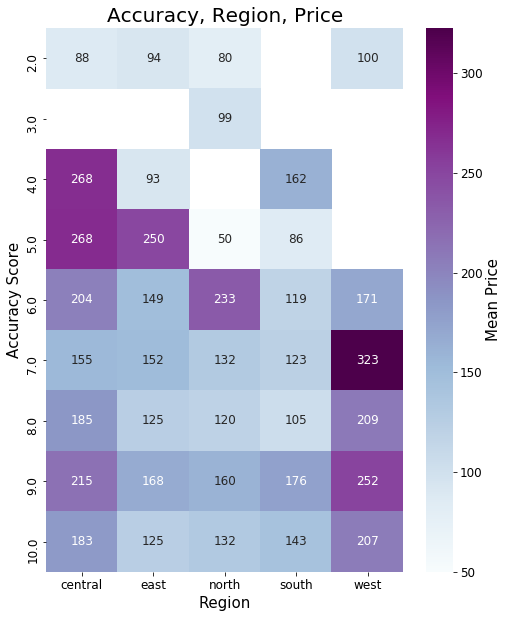

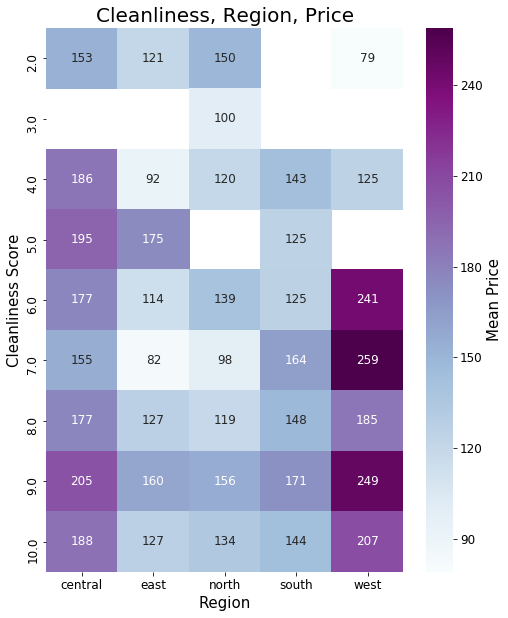

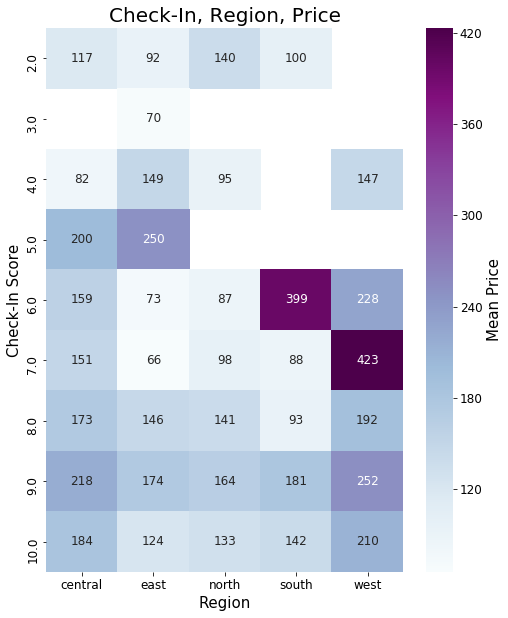

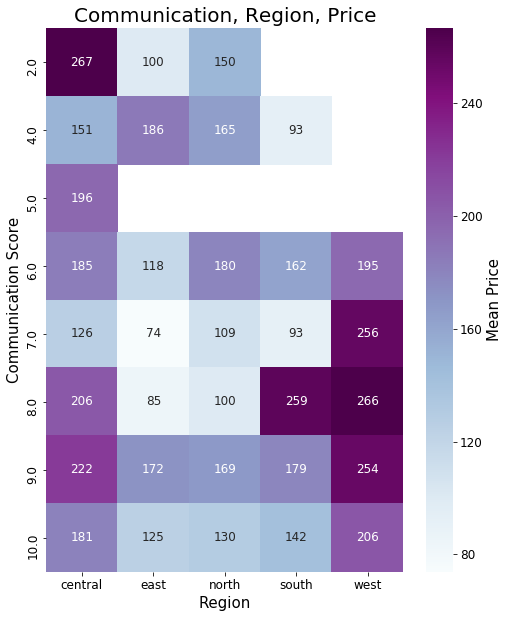

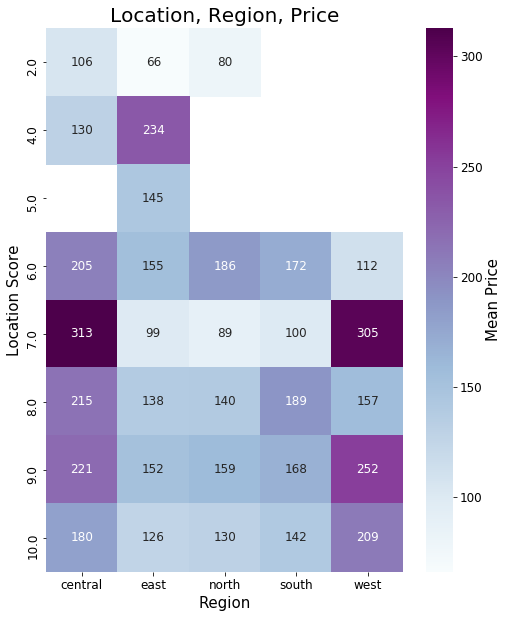

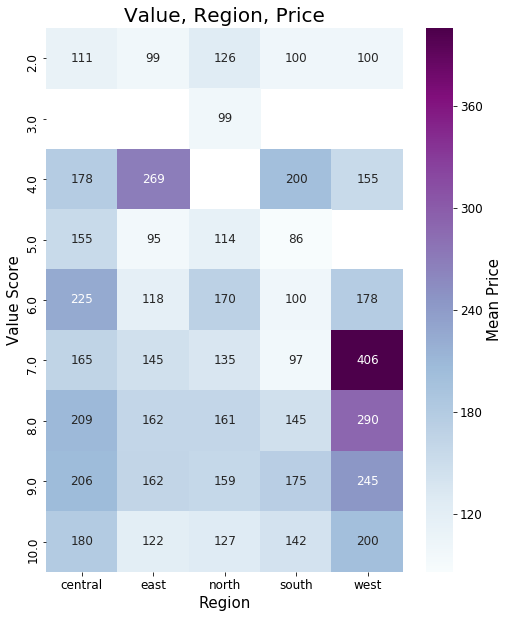

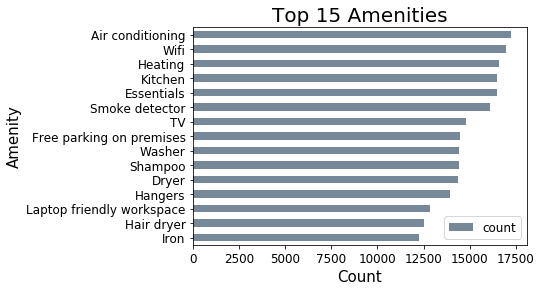

In [45]:
"""
EXECUTION CODE UNCOMMENT/DOCSTRING REMOVE TO RUN
"""
"""

Data_Exploration_0()
Data_Exploration_1()
Data_Exploration_2()
Data_Exploration_3()
Data_Exploration_4()
Data_Exploration_5()
Data_Exploration_6()
Data_Exploration_7()
Data_Exploration_8()
Data_Exploration_9()
Data_Exploration_10()
Data_Exploration_11()
Data_Exploration_12()
Data_Exploration_13()
Data_Exploration_14()
Data_Exploration_15()
Data_Exploration_16()
Data_Exploration_17()
Data_Exploration_18()
Data_Exploration_19()
Data_Exploration_20()
Data_Exploration_21()
Data_Exploration_22()
Data_Exploration_23()
Data_Exploration_24()
Data_Exploration_25()
Data_Exploration_26()
Data_Exploration_27()
Data_Exploration_28()
Data_Exploration_29()
Data_Exploration_30()
Data_Exploration_31()
Data_Exploration_32()

"""

## Modeling

#### Data Overview

In [46]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Modeling_0():
    global df
    
    # Extract features and target price from df_listings
    df = df_listings[feature_lst + ['price', 'square_feet', 'region']].copy().reset_index()
    
# Modeling_0()



In [47]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Modeling_1():
    # Take a final look at Distribution
    print(df['price'].describe())

# Modeling_1()



In [48]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Modeling_2():
    fig, axes = plt.subplots(1,2,figsize = (21,6))
    sns.distplot(df['price'], kde = True, ax = axes[0])
    sns.distplot(np.log1p(df['price']), ax=axes[1])
    axes[1].set_xlabel('log(1+price)')
    plt.show()

# Modeling_2()



In [49]:
#### One Hot Encode Categorical Features

In [50]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Modeling_3():
    
    global features
    global feature_lst
    global target
    global df
    global features_other
    
    include_amenities = False
    include_square_feet = False
    non_categorical = True
    
    if include_amenities:
        feature_lst.extend(amenity_lst)

    if include_square_feet:
        feature_lst.extend(['square_feet'])



    features = df[feature_lst].copy()
    target = df[['price']].copy()


    # convert object columns to categorical type
    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category')

    # one hot encode categories
    features_categorical = features.select_dtypes(include=['category']).copy()
    features_categorical = pd.get_dummies(features_categorical)


    # Extract all other features
    features_other = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()


    # Combine
    if non_categorical:
        features = features_other.copy()
    else:    
        features = pd.concat([features_other, features_categorical], axis=1)



# Modeling_3()







#### Test-Train Split

In [51]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Modeling_4():
    
    global X_train
    global X_test
    global y_train
    global y_test
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(features_other, target, test_size=0.2)


# Modeling_4()



#### Scaliing/Standardize Data


In [52]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Modeling_5():
    
    global X_train
    global X_test
    global y_train
    global y_test
    
    # standard scaler
    scaler = StandardScaler()


    X_train = X_train.copy()
    X_test = X_test.copy()


    X_train.loc[:,:] = scaler.fit_transform(X_train)
    X_test.loc[:,:]  = scaler.transform(X_test)


# Modeling_5()




#### Sci-kit Learn Pipeline

In [53]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Modeling_6():
    
    global results
    
    #Sci kit Pipeline
    models = [('SVR', SVR(kernel='linear')),
              ('Decision Tree Regression', DecisionTreeRegressor()),
              ('Linear Regression', LinearRegression()),
              ('KNeighbors Regression', KNeighborsRegressor(n_neighbors=7)),
              ('Random Forest Regression', RandomForestRegressor(n_estimators=100)),
              ('XGB Boost Regression', xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100))
             ]


    results = []

    for model in models:

        # Instantiate and fit Regressor Model
        m = model[1]

        if model[0] == "XGB Boost Regression":  
            m.fit(X_train, y_train)
        else:
            m.fit(X_train, y_train['price'])

        # Predict with model
        y_pred_test = m.predict(X_test)

        # Store and Print Results
        name = model[0]
        print(name)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        print(" TEST RMSE: {:.2f}".format(test_rmse))

        test_r2 = r2_score(y_test, y_pred_test)
        print(" TEST r2: {:.2f}".format(test_r2))


        results.append((name, test_r2, test_rmse))

# Modeling_6()


#### Sci-Kit Learn Results

In [54]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Modeling_7():
    df = pd.DataFrame(results, columns = ['model', 'r2', 'rmse']).set_index('model')

    df[['r2']].plot(kind='barh')
    plt.title("Model Comparison r2")


    if save_figs:
        plt.savefig("./plots/pipelineresults", bbox_inches='tight')
    else:
        plt.show()


# Modeling_7()



#### XG-Boost Grid Search


In [55]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""

def Modeling_8():
    
    global results
    
    scan = False
    if scan:
        import xgboost as xgb
        b = xgb.XGBRegressor(objective ='reg:squarederror')
        from sklearn.model_selection import GridSearchCV

        # Search Grid
        param_grid = {'n_estimators': [100, 150, 200, 400],
                      'learning_rate': [0.01, 0.02, 0.3, 0.4], 
                      'max_depth': [3, 4, 5, 6, 7, 10],
                      'colsample_bytree': [0.6, 0.7, 1],
                      'gamma': [0.0, 0.1, 0.2, 0.3]}

        # initialize searcher
        gs = GridSearchCV(b, param_grid, cv=3, n_jobs=-1)

        # fit model
        gs.fit(X_train, y_train)

        # store best results
        results = gs.best_params_

        print(results)


# Modeling_8()



#### XG-Boost Results

In [56]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Modeling_9():
    
    global b
    
    # create model
    b = xgb.XGBRegressor(objective ='reg:squarederror', 
                               colsample_bytree=0.7,
                               gamma=0.2,
                               learning_rate=0.1, 
                               max_depth=10,
                               n_estimators=450,
                               random_state=10)

    # fit model
    b.fit(X_train, y_train)

    # predict values
    y_pred_train = b.predict(X_train)
    y_pred_test = b.predict(X_test)


    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    print(" TRAIN RMSE: {:.2f}".format(train_rmse))

    train_r2 = r2_score(y_train, y_pred_train)
    print(" TRAIN r2: {:.2f}".format(train_r2))

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(" TEST RMSE: {:.2f}".format(test_rmse))

    test_r2 = r2_score(y_test, y_pred_test)
    print(" TEST r2: {:.2f}".format(test_r2))


# Modeling_9()


In [57]:
#### Important Features

In [58]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Modeling_10():
    
    top_x = 10
       
    # plot for split frequency    
    from xgboost import plot_importance
    fig, ax = plt.subplots(figsize = (10,5))
    plot_importance(b, max_num_features = top_x, ax = ax, color = 'dodgerblue')

    plt.title("Feature Importance (Split Frequency)")
    if save_figs:
        plt.savefig("./plots/importantfeaturesfrequency", bbox_inches='tight')
    else:
        plt.show()
        
    plt.clf()

    # plot for weights
    important_features = pd.Series(b.feature_importances_, index=features_other.columns)
    important_features.nlargest(top_x).sort_values().plot(kind='barh', color='crimson', figsize=(10,5))
    plt.xlabel('Feature Weights')
    plt.ylabel('Features')
    plt.title("Feature Importance (Weight)")


    if save_figs:
        plt.savefig("./plots/importantfeaturesweight", bbox_inches='tight')
    else:
        plt.show()     
        
    # print 
    print(important_features.nlargest(20).sort_values())

# Modeling_10()



In [59]:
#### Cross Validation

In [60]:
"""
EXECUTION CODE UNCOMMENT TO RUN
"""
def Modeling_11():
    bst = xgb.DMatrix(data=X_train, label=y_train)

    params = {'colsample_bytree':0.7,
              'gamma':0.2,
              'learning_rate':0.01,
              'max_depth':10}


    cv = xgb.cv(dtrain= bst,
                        params=params,
                        nfold=3,
                        num_boost_round=400,
                        early_stopping_rounds=10, 
                        metrics="rmse", as_pandas=True)


    print(cv.tail())
    
    return(bst)
# Modeling_11()



count    17542.000000
mean       176.107855
std        134.177348
min         33.000000
25%         80.000000
50%        130.000000
75%        225.000000
max        660.000000
Name: price, dtype: float64


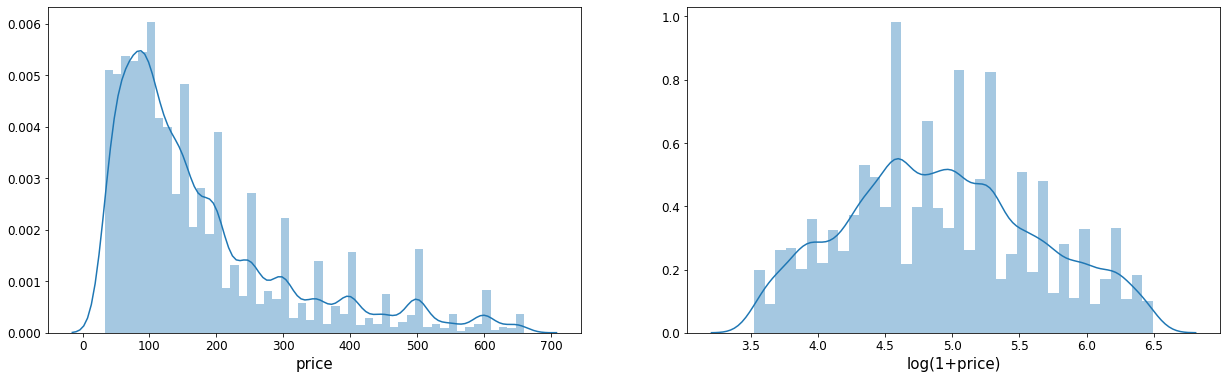

SVR
 TEST RMSE: 108.02
 TEST r2: 0.33
Decision Tree Regression
 TEST RMSE: 122.15
 TEST r2: 0.14
Linear Regression
 TEST RMSE: 104.38
 TEST r2: 0.37
KNeighbors Regression
 TEST RMSE: 97.32
 TEST r2: 0.45
Random Forest Regression
 TEST RMSE: 87.57
 TEST r2: 0.56
XGB Boost Regression
 TEST RMSE: 91.93
 TEST r2: 0.51
 TRAIN RMSE: 27.06
 TRAIN r2: 0.96
 TEST RMSE: 85.99
 TEST r2: 0.57
review_scores_rating           0.021861
crime_rate_zipcode             0.022736
review_scores_communication    0.023961
review_scores_cleanliness      0.024387
review_scores_location         0.024430
review_scores_value            0.025035
review_scores_checkin          0.028733
guests_included                0.032318
security_deposit               0.032564
zipcode                        0.033966
cleaning_fee                   0.034002
maximum_nights                 0.034149
number_of_reviews              0.037710
extra_people                   0.042276
crime_rate_region              0.043263
minimum_nights  

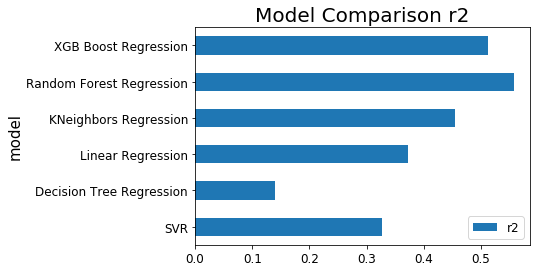

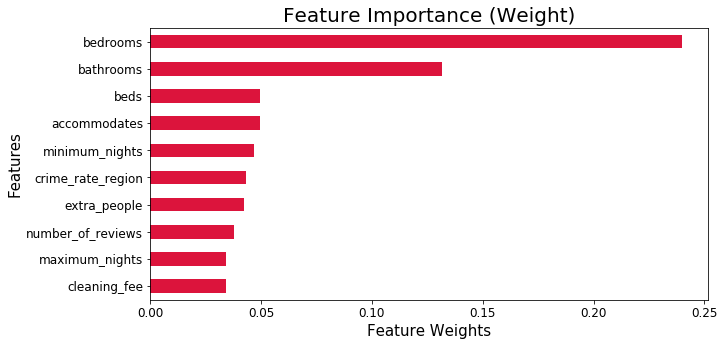

In [61]:
"""
EXECUTION CODE UNCOMMENT/DOCSTRING REMOVE TO RUN
"""

"""

Modeling_0()
Modeling_1()
Modeling_2()
Modeling_3()
Modeling_4()
Modeling_5()
Modeling_6()
Modeling_7()
Modeling_8()
Modeling_9()
Modeling_10()
bst = Modeling_11()

"""

## Presentation Graphic(s)

I spent a lot of time in the Data Exploration phase looking at relationships of features through graphs. The graphs that I felt were meaningful I worked on to formalize and saved those figures. Here are The functions for those graphs.

- Data_Exploration_1() Price Boxplot
- Data_Exploration_3() Price Distributions
- Data_Exploration_10() Correlation Matrix
- Data_Exploration_11() Crime by Region
- Data_Exploration_13() Price Map
- Data_Exploration_15() Price by Region
- Data_Exploration_17() Property Types by Region
- Data_Exploration_18() Room Type Accomodates Price
- Data_Exploration_19() Bedrooms Region Price
- Data_Exploration_20() Bedrooms Bed Price
- Data_Exploration_21() Bedrooms Bathroom Price
- Data_Exploration_22() Ratings Region Price
- Data_Exploration_23() Accuracy Region Price
- Data_Exploration_24() Cleanliness Region Price
- Data_Exploration_25() Check-In Region Price
- Data_Exploration_26() Communication Region Price
- Data_Exploration_27() Location Region Price
- Data_Exploration_28() Value Region Price
- Data_Exploration_32() Top 15 Amenities
- Modeling_7() Top 15 Pipeline Results
- Modeling_10() Top 10 Features Frequency
- Modeling_10() Top 10 Features Weight










## Project approach and overall execution
Do not put anything below this cell

## Code Structure and Organization

## Code Commenting